In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
plt.rcParams['legend.handlelength'] = 0

from AnalyseCID import AnalyseCID
from utils import *
from utils_plot import *

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [ ]:
base_path = f'Z:\\cid\\na'
save_path = f'data\\nematic\\na'

extract = False
analyze = False
save_figs = True
verbose = True

data_suffix = 'ndg'  # 'sd', 'ndg' or ''    
use_seq = True

nbits = 6
cg = 4

data_dict = {}
sd_data_dict = {'data_suffix': 'sd',
    'output_suffix': f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [512],
    'Nexp_list': [10],
    'act_exclude_dict': {512: []},
    'act_critical': 0.022
}
na_data_dict = {
    'data_suffix': '',
    'output_suffix': f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [512, 1024, 2048],
    'Nexp_list': [5]*3,
    'act_exclude_dict': {512: [0.02, 0.0225], 1024: [], 2048: [0.0225]},
    'act_critical': 0.022
}
ndg_data_dict = {
    'data_suffix': 'ndg',
    'output_suffix': f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [1024],
    'Nexp_list': [1],
    'act_exclude_dict': {1024: []},
    'act_critical': 0.65
}
data_dict = {'sd': sd_data_dict, 'ndg': ndg_data_dict, '': na_data_dict}

cid_dict = {
    'base_path': base_path,
    'save_path': save_path,
    'nbits': nbits,
    'cg': cg,
    'verbose': verbose,
    'ddof': 1,
    **data_dict[data_suffix]
}
output_suffix = data_dict[data_suffix]['output_suffix']
fig_folder = 'na' if data_suffix == '' else data_suffix
figs_save_path = f'data\\nematic\\figs\\{fig_folder}\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): 
    os.makedirs(figs_save_path)


ac = AnalyseCID(cid_dict, load_data=True)

# Set figure save path
ac.figs_save_path = figs_save_path

if extract:
    ac.run()
if analyze and not extract:
    ac.analyze()



TODO:

On the spatial CID analysis:
- CID/div scaling under window size
- a dir-dir analogous correlation function on the 
- flow or gradients of cid

- how do we absolve we posisition dependence to results for relative positions? eg with corr func


In [38]:
def plot_thermodynamic_efficiency(L_list, act_dict, entropy_deriv_dict, order_param_dict, zero_response_val, \
                            shift_act = False, xlims=None, plot_abs=False, savepath=None):
    """
    Plot CID variance and derivative vs activity for different system sizes.

    Parameters:
    ----------
    L_list : list
        List of system sizes (e.g., [16, 32, 64, 128]).
    act_dict : dict
        Dictionary mapping system size to activity list.
    entropy_deriv_dict : dict
        Dictionary mapping system size to av. entropy derivative w.r.t. control param.
        Each value should be an array with shape (n-1, 2): [mean, sem].
    order_param_dict : dict
        Dictionary mapping system size to order parameter data.
        Each value should be an array with shape (n, 2): [mean, sem].
    zero_response_val : float
        Value of the order parameter at which the response is zero.
    xlims : list, default [0, None]
        x-axis limits for the plots.
    plot_abs : bool, default False
        Whether to plot the absolute value of the derivative.
    savepath : str, default None
        Path where the figure is saved if not None

    Returns:
    -------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
        The created figure and axes.
    """

    ncols = len(L_list)
    w = 4 * ncols
    #w += 1 if ncols < 3 else 0
    fig, ax0 = plt.subplots(ncols=ncols, figsize=(w,4))
    marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
    
    if plot_abs:
        dylabel_per = r'$\vert \frac{d\textrm{CID}}{d\tilde{\zeta}}\vert/\vert\textrm{CID} \vert$'
        dylabel = r'$\vert d\textrm{CID}/d\tilde{\zeta}\vert$'
    else:
        dylabel_per = r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}/\textrm{CID}$'
        dylabel = r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}$'

    for i, LX in enumerate(L_list):
        ax = ax0 if ncols == 1 else ax0[i]

        act_list = act_dict[LX]
        order_para = order_param_dict[LX].copy()
        entropy_deriv = entropy_deriv_dict[LX].copy()
        if shift_act:
            act_list =  act_list[:-1] + np.diff(act_list) / 2
            order_para = 0.5 * (order_para[:-1] + order_para[1:])
        else:
            if len(entropy_deriv) < len(act_list):
                act_list =  act_list[:-1]
                order_para = order_para[:-1]
        thermo_eff = - entropy_deriv[:,0] / (zero_response_val - order_para[:,0])
        thermo_eff_sem = np.abs(thermo_eff) * np.sqrt( (entropy_deriv[:,1]/entropy_deriv[:,0])**2 + (order_para[:,1]/order_para[:,0])**2 )

        if plot_abs:
            thermo_eff = np.abs(thermo_eff)
            entropy_deriv[:,0] = np.abs(entropy_deriv[:,0])


        ax.errorbar(act_list, thermo_eff,yerr=thermo_eff_sem,
            fmt=marker_shape[1],
            lw=1, 
            elinewidth=1.5, alpha=0.6, label =r'$\eta_\textrm{eff}$')
        ax.errorbar(act_list, entropy_deriv[:,0], yerr=entropy_deriv[:,1],
            fmt=marker_shape[1],
            lw=1, 
            elinewidth=1.5, alpha=0.6, label =dylabel)
        
    ax = [ax0] if ncols == 1 else ax0
    for axx in ax:
        axx.set(xlabel=r'Activity ($\tilde{\zeta}$)')
        xlim = axx.get_xlim() if xlims is None else xlims
        axx.set_xlim(xlim)
        axx.set_ylim(axx.get_ylim())
        axx.hlines(0, xlim[0], xlim[1], colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        axx.legend()

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
        print(f"Figure saved to: {savepath}")
    return fig, ax

In [ ]:
dcid_central_dict = {}
for L in ac.L_list:
    dcid_central = calc_tangent(
        np.array(ac.act[L]),
        ac.cid_tav[L][:,0],
        ac.cid_tav[L][:,1],
    )
    dcid_central_dict[L] = dcid_central

response_zero_val = .12
fig, ax = plot_thermodynamic_efficiency(
    ac.L_list,
    ac.act,
    ac.dcid,#dcid_central_dict,
    ac.cid_tav,
    response_zero_val,
    shift_act=False,
    xlims=None, #[0, 0.05],
    plot_abs=True,)
for a in ax:
    a.vlines(0.022, 0,200, colors='red', linestyles='dashed', lw=1, alpha=0.8)

In [ ]:
vals=ac.frac[2048][:,...,0].copy()
vals_err =ac.frac[2048][:,...,1].copy()
vals_err=0
var_mask = (vals+vals_err >= 1)
vals[var_mask] = np.nan
av,var,varper = calc_time_avs_ind_samples(vals, ac.conv[2048],Nexp=5, ddof=1,) # uncertainty_multiplier=cid_dict['uncertainty_multiplier'])

moment_dict = {}
div_moment_dict = {}
for LX in ac.L_list:
    vals=ac.frac[LX][:,...,0].copy()
    vals_err =ac.frac[LX][:,...,1].copy()
   # var_mask = (vals >=1)
   # vals[var_mask] = np.nan
    vals_err=0
    var_mask = (vals+vals_err >= 1)
    vals_err=0
    print(var_mask.sum(), (vals>1).sum()    )
    vals[var_mask] = np.nan
    moment_dict[LX] = calc_moments(ac.cid[LX][...,0], ac.conv[LX], Nexp = ac.Nexp[LX],)
    div_moment_dict[LX] = calc_moments(1-vals, ac.conv[LX], Nexp = ac.Nexp[LX],)

fig, ax = plot_moments(div_moment_dict, act_dict=ac.act, L_list=ac.L_list[:], moment_label=r'$\mathcal{D}$',\
                     plot_binder=False, )
for a in ax:
    a.legend(fontsize=8)
    a.set_xlim(0.015,0.035)  

plt.errorbar(ac.act[2048], varper[:,0],varper[:,1], marker='o', linestyle='-', label='NA data')
plt.errorbar(ac.act[2048], ac.frac_var[2048][:,0], ac.frac_var[2048][:,1], marker='o', linestyle='--', label='Original analysis')
plt.legend()


fig, ax = plt.subplots(ncols=5,figsize=(16,4))
for i in range(5):
    j=i+3
    Vals = vals[:,...,j,:] #+ vals_err[:,...,j,:]
    ValsOrig = ac.frac[2048][:,...,j,:,0].copy()
    print(np.nanvar(ValsOrig), np.nanvar(Vals), np.var(Vals[~np.isnan(Vals)]))

    ax[i].hist(Vals.flatten(), bins=20, density=True);
    ax[i].hist(ValsOrig.flatten(), bins=20, alpha=0.5, color='orange', density=True);
    ax[i].set_title(f'act {ac.act[2048][j]:.4f}');

In [ ]:
LX=1024
cid_valss = cid_dict[LX][...,0].copy()
cid_min=np.nanmin(cid_valss)
cid_mask = cid_valss < cid_min
cid_valss[cid_mask] = np.nan
cid_av, varall, varper = calc_time_avs_ind_samples(cid_valss, conv_dict[LX], unc_multiplier=20)
cid_moms=calc_moments(cid_valss, conv_dict[LX])
plot_moments({LX: cid_moms}, act_dict, L_list=[LX], moment_label='cid');

div_valss = 1-frac_dict[LX][...,0].copy()   
div_mask = div_valss <= 0
div_valss[div_mask] = 0#np.nan
div_av, varall, varper = calc_time_avs_ind_samples(div_valss, conv_dict[LX], unc_multiplier=20)
moms=calc_moments(div_valss, conv_dict[LX])
fig, ax = plot_moments({LX: moms}, act_dict, L_list=[LX], moment_label='cid');
for a in ax:
    a.set_xlim(xmax=0.05)
act=0.023
actidx = np.where(act_dict[LX]==act)[0]
for exp in range(5):
    plt.hist(cid_valss[2:,:,actidx,exp].flatten(),bins=50, alpha=.3);


In [ ]:

for i, LX in enumerate(L_list):
    binder = np.nanmean(cid_dict[LX][...,:,0] ** 4, axis=(0,1,-1)) / (np.nanmean(cid_dict[LX][...,:,0] ** 2, axis=(0,1,-1)) ** 2)
    print(binder.shape)
    plt.plot(act_dict[LX], binder, marker='o', label=f'L={LX}', linestyle='-')
plt.legend()
plt.xlim(0.018,0.055)

In [ ]:
for i, nexp in enumerate(range(cid_arr.shape[-2])):
    cid_vals = cid_arr[:,:,-2,i,0,].mean(axis=(1,))
    plt.plot(np.arange(ncubes), cid_vals, label=f'Exp {i}')
plt.legend()

bins=30
rexp=0
nframes=cid_arr.shape[0]
plt.hist(cid_arr[0:5, :, -2, :,0 ].flatten(),bins=bins, label='t=0', alpha=0.5, density=True);
plt.hist(cid_arr[50:55, :, -2, :,0 ].flatten(),bins=bins, label=f't={nframes//2}', alpha=0.5, density=True);
plt.hist(cid_arr[300:305, :, -2, :,0 ].flatten(),bins=bins, label=f't=3', alpha=0.5, density=True);
#plt.hist(cid_arr[nframes//5, :, -2, rexp,0 ].flatten(),bins=bins, label=f't={nframes//5}', alpha=0.5);
#plt.hist(cid_arr[nframes//10, :, -2, rexp,0 ].flatten(),bins=bins, label=f't={nframes//10}', alpha=0.5);
plt.legend(handlelength=1);

In [ ]:
moment_dict = {}
div_moment_dict = {}
for LX in L_list:
    moment_dict[LX] = calc_moments(cid_dict[LX][...,0], conv_dict[LX],)
    div_moment_dict[LX] = calc_moments(1-frac_dict[LX][...,0], conv_dict[LX],)

fig, ax = plot_moments(moment_dict, act_dict=act_dict, L_list=L_list[1:], moment_label=r'CID',\
                        plot_binder=False, \
                    savepath=os.path.join(figs_save_path, f'cid_moments{output_suffix}.pdf'))

fig, ax = plot_moments(div_moment_dict, act_dict=act_dict, L_list=L_list[1:], moment_label=r'$\mathcal{D}$',\
                     plot_binder=False, \
                    savepath=os.path.join(figs_save_path, f'div_moments{output_suffix}.pdf'))

... and now for something completely different

In [ ]:
for num_exp in range(nexp):
    plt.plot(range(ncubes), np.nanmean(cid_frac_arr[:,:,act_idx,num_exp,0], axis=1), label=f'Exp {num_exp}')
plt.plot(range(ncubes), frac_sav[:,act_idx,0],'x', label=f'av')
plt.plot(range(ncubes), frac_savw[:,act_idx,0],'d', label=f'avw')
plt.legend()

In [ ]:
idx=4
#plt.hist(cid_arr[:,:,act_idx,idx,0].flatten(), bins=100, range=(0,0.2), alpha=.3);
#plt.hist(cid_shuffle_arr[:,:,act_idx,idx,0].flatten(), bins=100, range=(0,0.2), alpha=.3);
plt.hist(cid_frac_arr[:,:,act_idx,idx,1].flatten(), bins=100, alpha=.3);

In [ ]:
plt.imshow(frac_tav[:,3,0].reshape(4,4), #vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,4,0,4]   
        )

array([0.0195, 0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 ,
       0.0235, 0.024 , 0.0245, 0.025 , 0.0255, 0.026 , 0.027 , 0.028 ,
       0.029 , 0.03  , 0.032 , 0.034 , 0.04  , 0.05  , 0.06  , 0.07  ,
       0.08  , 0.09  , 0.1   , 0.15  , 0.2   ])

In [ ]:
nboxes_per_side = int(np.sqrt(npartitions))
vmin, vmax = None, None
actidx = act_idx
fig, ax = plt.subplots(ncols=2,figsize=(12,7))
ax[0].imshow(frac_tav[:,actidx,0].reshape(nboxes_per_side,nboxes_per_side), vmin=vmin, vmax=vmax,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]   
        )
ax[1].imshow(frac_tavw[:,actidx,0].reshape(nboxes_per_side,nboxes_per_side), vmin=vmin, vmax=vmax,#vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]  ) 
#fig.colorbar(ax[0].images[0], ax=ax[0], label='CID / CID shuffle')
fig.colorbar(ax[1].images[0], ax=ax[1],)# label='CID / CID shuffle')

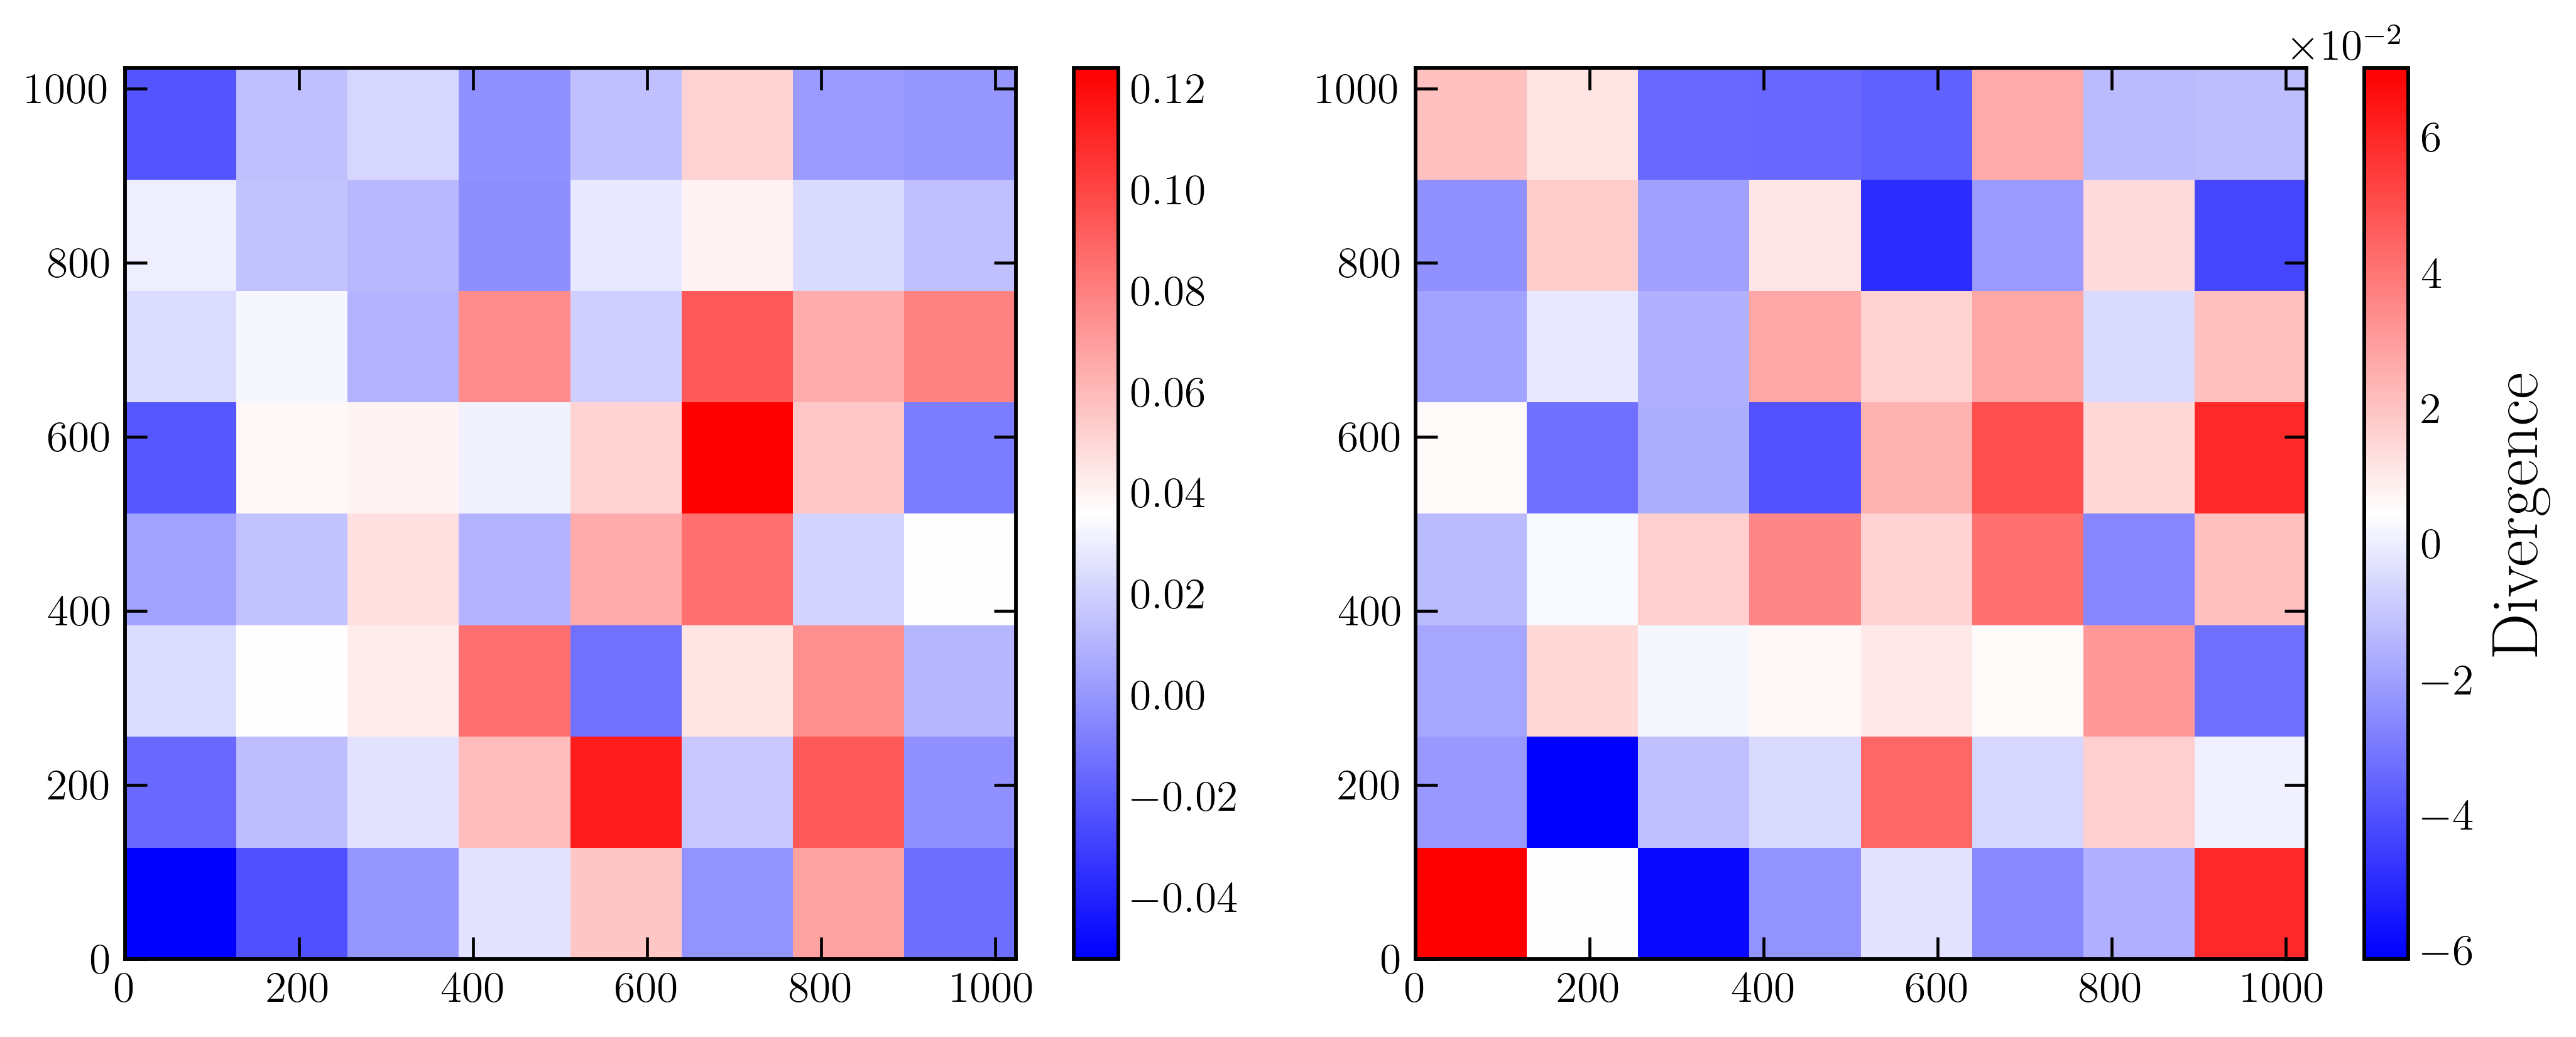

In [32]:
LX = 1024
npartitions = (1024 // (1<<nbits) // cg)**2
nexp=3
tf = 6

shift = True
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
compression = int(np.sqrt(npartitions))
actidx = np.where(act_dict[LX]==0.022)[0][0]
cid_grid_av = np.nanmean(cid_dict[LX][tf,:,actidx, nexp, 0])
cid_grid_av = calc_weighted_mean(cid_dict[LX][tf,:,actidx, nexp, 0], cid_dict[LX][tf,:,actidx, nexp, 1])[0]
div_grid_av = np.nanmean(frac_dict[LX][tf,:,actidx, nexp, 0])
cid_grid = cid_dict[LX][:,:,actidx, nexp, 0].reshape(ncubes, compression, compression)
div_grid = frac_dict[LX][:,:,actidx, nexp, 0].reshape(ncubes, compression, compression)
if shift:
    cid_grid[tf] -= cid_grid_av
    #div_grid[tf] -= div_grid_av
ax[0].imshow(cid_grid[tf], cmap='bwr', origin='lower', extent=[0,LX, 0,LX])
fig.colorbar(ax[0].images[0], ax=ax[0],)
ax[1].imshow(div_grid[tf], cmap='bwr', origin='lower', extent=[0,LX,0,LX])
fig.colorbar(ax[1].images[0], ax=ax[1], label='Divergence')

In [ ]:
nboxes_per_side = int(np.sqrt(npartitions))
vmin, vmax = None, None
actidx = act_idx
fig, ax = plt.subplots(ncols=2,figsize=(12,7))
ax[0].imshow(frac_tav[:,actidx,0].reshape(nboxes_per_side,nboxes_per_side), vmin=vmin, vmax=vmax,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]   
        )
ax[1].imshow(frac_tavw[:,actidx,0].reshape(nboxes_per_side,nboxes_per_side), vmin=vmin, vmax=vmax,#vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]  ) 
#fig.colorbar(ax[0].images[0], ax=ax[0], label='CID / CID shuffle')
fig.colorbar(ax[1].images[0], ax=ax[1],)# label='CID / CID shuffle')

In [ ]:
nboxes_per_side = int(np.sqrt(npartitions))
plt.imshow(frac_tavw[:,act_idx,0].reshape(nboxes_per_side,nboxes_per_side), #vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,nboxes_per_side,0,nboxes_per_side]   
        )
plt.colorbar(label='CID / CID shuffle')


In [ ]:
# plot mean and std of cid_arr, cid_shuffle_arr, cid_frac_arr over nexp for each act
ncols=5
actidx_min=2
fig, ax = plt.subplots(nrows=2,ncols=ncols,figsize=(15,8))
for j, act in enumerate(act_list[actidx_min:actidx_min+ncols]):
    i = j + actidx_min
    ax[0, j].errorbar(np.arange(ncubes), frac_sav[:,i,0], yerr=frac_sav[:,i,1], fmt='.', label=f'act={act}',alpha=.3,ms=1)
    ax[0, j].hlines(np.nanmean(frac_sav[:,i,0]), 0, ncubes-1, colors='r', linestyles='--', label='mean last 10')
    ax[0, j].set_title(f'act={act:.4f}')
    ax[1, j].errorbar(np.arange(ncubes), frac_savw[:,i,0], yerr=frac_savw[:,i,1], fmt='.', label=f'act={act}',alpha=.3,ms=1)
    ax[1, j].hlines(np.nanmean(frac_savw[:,i,0]), 0, ncubes-1, colors='r', linestyles='--', label='mean last 10')
   #ax[1,i].set_title(f'act={act:.4f}')
                                                                   

In [ ]:
act_expanded = np.repeat(np.array(act_list)[None,:], npartitions, axis=0)
act_expanded = np.repeat(act_expanded[None,:,:], ncubes, axis=0)
act_expanded = np.repeat(act_expanded[:,:,:,None], nexp, axis=2)
plt.scatter(act_expanded, cid_frac_arr[:,:,:,:,0], marker='.', alpha=0.1)
plt.ylim(.6,1.1)
plt.xscale('log')